
Processando coluna: cap-shape
Treinando Random Forest para imputação...
Taxa de acerto Random Forest: 13.48%
Taxa de acerto moda global: 49.11%

Processando coluna: cap-surface
Treinando Random Forest para imputação...
Taxa de acerto Random Forest: 19.77%
Taxa de acerto moda global: 41.58%

Processando coluna: bruises
Treinando Random Forest para imputação...
Taxa de acerto Random Forest: 100.00%
Taxa de acerto moda global: 57.62%

Processando coluna: odor
Treinando Random Forest para imputação...
Taxa de acerto Random Forest: 87.59%
Taxa de acerto moda global: 50.18%

Processando coluna: gill-color
Treinando Random Forest para imputação...
Taxa de acerto Random Forest: 2.04%
Taxa de acerto moda global: 24.11%


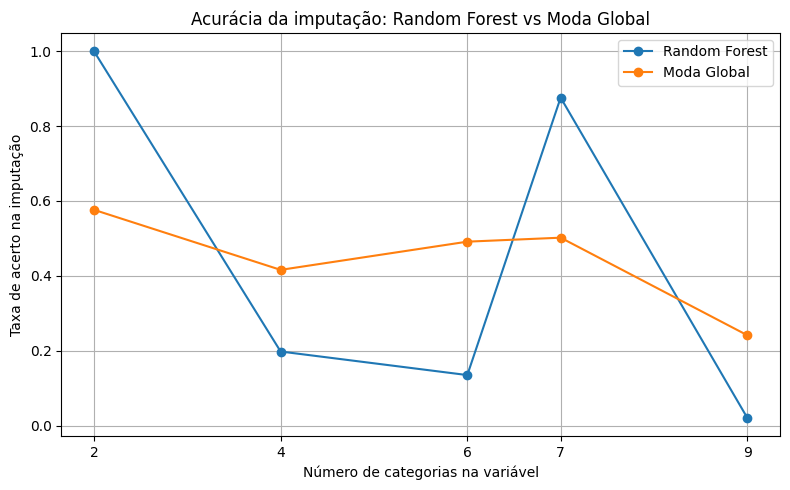

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

# 1. Carregar dados
file_path = 'mushrooms_data/agaricus-lepiota.data'
columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv(file_path, header=None, names=columns)
df.replace('?', np.nan, inplace=True)
df_full = df.dropna().reset_index(drop=True)  # usar apenas linhas completas

# Colunas para testar
test_cols = ['cap-shape', 'cap-surface', 'bruises', 'odor', 'gill-color']

# Parâmetros
missing_rate = 0.2
np.random.seed(42)

# Resultados
num_categories = []
accuracy_rf = []
accuracy_mode = []

for col in test_cols:
    print(f"\nProcessando coluna: {col}")
    
    df_missing = df_full.copy()
    n_missing = int(len(df_missing) * missing_rate)
    missing_indices = np.random.choice(df_missing.index, size=n_missing, replace=False)
    df_missing.loc[missing_indices, col] = np.nan
    
    # Codificação ordinal de todas as colunas
    encoder = OrdinalEncoder()
    df_encoded = df_missing.copy()
    df_encoded[df_encoded.columns] = encoder.fit_transform(df_encoded)
    
    # Separar dados completos para treinamento
    train_data = df_encoded.dropna(subset=[col])
    test_data = df_encoded.loc[missing_indices].drop(columns=[col])
    
    # Treinar Random Forest
    print("Treinando Random Forest para imputação...")
    X_train = train_data.drop(columns=[col])
    y_train = train_data[col]
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Imputar com RF
    df_imputed_rf = df_missing.copy()
    y_pred = rf.predict(test_data)
    
    # Desfazer codificação para comparação
    col_index = df_encoded.columns.get_loc(col)
    y_pred_labels = encoder.categories_[col_index][y_pred.astype(int)]
    df_imputed_rf.loc[missing_indices, col] = y_pred_labels

    # Imputação por moda global
    df_imputed_mode = df_missing.copy()
    global_mode = df_full[col].mode().iloc[0]
    df_imputed_mode.loc[missing_indices, col] = global_mode

    # Avaliar acurácia
    true_values = df_full.loc[missing_indices, col]
    pred_rf = df_imputed_rf.loc[missing_indices, col]
    acc_rf = (true_values == pred_rf).mean()

    pred_mode = df_imputed_mode.loc[missing_indices, col]
    acc_mode = (true_values == pred_mode).mean()

    num_categories.append(df_full[col].nunique())
    accuracy_rf.append(acc_rf)
    accuracy_mode.append(acc_mode)

    print(f"Taxa de acerto Random Forest: {acc_rf:.2%}")
    print(f"Taxa de acerto moda global: {acc_mode:.2%}")

# Ordenar resultados
results = pd.DataFrame({
    'num_categories': num_categories,
    'accuracy_rf': accuracy_rf,
    'accuracy_mode': accuracy_mode
}).sort_values(by='num_categories')

# Plot
plt.figure(figsize=(8, 5))
plt.plot(results['num_categories'], results['accuracy_rf'], marker='o', label='Random Forest')
plt.plot(results['num_categories'], results['accuracy_mode'], marker='o', label='Moda Global')
plt.xticks(results['num_categories'])
plt.xlabel('Número de categorias na variável')
plt.ylabel('Taxa de acerto na imputação')
plt.title('Acurácia da imputação: Random Forest vs Moda Global')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


| Coluna      | RF (%) | Moda (%) | Comentário rápido               |
| ----------- | ------ | -------- | ------------------------------- |
| cap-shape   | 13.48  | 49.11    | RF muito ruim, moda ganha fácil |
| cap-surface | 19.77  | 41.58    | RF ruim, moda melhor            |
| bruises     | 100.00 | 57.62    | RF perfeito, claro padrão       |
| odor        | 87.59  | 50.18    | RF muito bom, moda razoável     |
| gill-color  | 2.04   | 24.11    | RF péssimo, moda muito melhor   |


Por que a RF foi tão ruim em algumas colunas?
Dados categóricos complexos e codificação
Embora você tenha usado OneHotEncoder, talvez as features não estejam informando o modelo o suficiente para prever a coluna faltante, principalmente em colunas com muitas categorias e pouco padrão claro.

Colunas com alta cardinalidade e baixa correlação
Por exemplo, “gill-color” e “cap-shape” podem ter muitas categorias e pouca relação direta com as outras variáveis, dificultando a predição.

Problemas de separação treino/teste
O conjunto de treino não inclui as linhas com missing, que podem ter padrões diferentes, o que pode levar o RF a generalizar mal.

Colunas muito desbalanceadas
A moda pode ser alta justamente porque uma categoria domina a coluna, então adivinhar sempre a moda acerta muito.

Por que a RF foi perfeita em "bruises"?
"bruises" provavelmente tem poucos valores possíveis e tem padrão claro que o modelo consegue captar (por exemplo, presença ou ausência de machucados pode estar muito relacionada a outras características).

Isso facilita a predição, quase uma regra bem definida.

Por que a RF foi boa em "odor"?
O odor deve ter um padrão mais forte ligado às outras características do cogumelo, então a RF consegue usar as outras features para prever o valor com alta precisão.

Em resumo:
Moda vence onde o padrão é forte e simples (colunas desbalanceadas).

Random Forest funciona muito bem quando há relações claras e dados informativos (bruises, odor).

Quando as categorias são muitas e não há padrão forte, RF pode falhar e até ser pior que moda.

Não é que Random Forest não funcione com dados categóricos, mas depende da informação disponível e como os dados se relacionam.

